### Setup

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import warnings
import csv
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score, roc_curve, accuracy_score
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold, train_test_split, ParameterGrid, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector, RFECV
from imblearn.over_sampling import SMOTE
import shap

In [2]:
warnings.filterwarnings('ignore')

### Load Data

In [ ]:
# Read in Data Table
node_df = pd.read_csv("airport_features.csv")

In [4]:
# Return Class Distribution (13:1 Distribution)
node_df['binary_incident_observed'].value_counts()

0    1622
1     311
Name: binary_incident_observed, dtype: int64

### Clean Data

In [8]:
# Remove variables with > 0.8 correlation
correlated_vars_80 = ['NATIONAL POLICIES AND LAWS', 'degree_in_full', 'JUDICIAL SYSTEM AND DETENTION', 'in_cites_2018'
                      , 'STATE-EMBEDDED ACTORS', 'ECONOMIC REGULATORY CAPACITY', 'RESILIENCE (AVERAGE)'
                      , 'degree_out_full', 'INTERNATIONAL COOPERATION', 'eigen_full', 'close_full','pr_full']
node_df_trimmed_80 = node_df[[col for col in node_df.columns if col not in correlated_vars_80]]
node_df_trimmed_80.columns

Index(['IATA', 'id', 'name', 'city', 'country', 'ICAO', 'latitude',
       'longitude', 'altitude', 'timezone', 'dst', 'tz', 'type', 'source',
       'CRIMINAL ACTORS (AVERAGE)', 'MAFIA-STYLE GROUPS', 'CRIMINAL NETWORKS',
       'FOREIGN ACTORS', 'CRIMINAL MARKETS (AVERAGE)', 'HUMAN TRAFFICKING',
       'HUMAN SMUGGLING', 'ARMS TRAFFICKING', 'FLORA CRIMES', 'FAUNA CRIMES',
       'NON-RENEWABLE\nNON-RENEWABLE RESOURCE CRIMES', 'HEROIN TRADE',
       'COCAINE TRADE', 'CANNABIS TRADE', 'SYNTHETIC DRUG TRADE',
       'POLITICAL LEADERSHIP AND GOVERNANCE',
       'GOVERNMENT TRANSPARENCY AND ACCOUNTABILITY', 'LAW ENFORCEMENT',
       'TERRITORIAL INTEGRITY', 'ANTI-MONEY LAUNDERING SYSTEMS',
       'VICTIM AND WITNESS SUPPORT', 'PREVENTION', 'NON-STATE ACTORS',
       'population', 'in_cites_2021', 'in_cites_2016', 'in_cites_2017',
       'in_cites_2019', 'in_cites_2020', 'degree_full', 'between_full',
       'origin_count', 'transit_count', 'destination_count', 'seizure_count',
       'inc

### Modeling Functions

In [7]:
def balanced_random_forest(X_scaled,y):
    
    # Initialize Balanced Random Forest Classifier
    balanced_rf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_pred_cv = cross_val_predict(balanced_rf, X_scaled, y, cv=cv)
    y_pred_proba_cv = cross_val_predict(balanced_rf, X_scaled, y, cv=cv, method='predict_proba')

    # Print Performance
    print(classification_report(y, y_pred_cv))
    roc_auc = roc_auc_score(y, y_pred_proba_cv[:, 1])
    print("ROC AUC Score (predicted probabilities):", roc_auc)
    weighted_f1 = f1_score(y, y_pred_cv, average='weighted')
    print(f"Weighted F1 Score: {weighted_f1}")

    # Identify false positives and false negatives
    false_positive_indices = (y == 0) & (y_pred_cv == 1)
    false_negative_indices = (y == 1) & (y_pred_cv == 0)
    print(f"Number of false positives identified: {np.sum(false_positive_indices)}")
    print(f"Number of false negatives identified: {np.sum(false_negative_indices)}")

    # Ensure that the identified false positives and false negatives are correct
    # Filter the rows from node_df using the identified indices
    false_positive_records_df = node_df[false_positive_indices].copy()
    false_negative_records_df = node_df[false_negative_indices].copy()

    # Add a new column 'label' to each DataFrame
    false_positive_records_df['label'] = 'false_positive'
    false_negative_records_df['label'] = 'false_negative'

    # Add the probabilities for each record
    false_positive_records_df['probabilities'] = list(y_pred_proba_cv[false_positive_indices])
    false_negative_records_df['probabilities'] = list(y_pred_proba_cv[false_negative_indices])

    # Verify the probabilities match the predictions
    false_positive_records_df['predicted_class'] = y_pred_cv[false_positive_indices]
    false_positive_records_df['true_class'] = y[false_positive_indices]
    false_negative_records_df['predicted_class'] = y_pred_cv[false_negative_indices]
    false_negative_records_df['true_class'] = y[false_negative_indices]

    # Create DataFrame with all records
    data = {
        'true_value': y,
        'predicted_value': y_pred_cv,
        'confidence_list': y_pred_proba_cv.tolist()  # Convert to list for easier manipulation
    }
    df = pd.DataFrame(data)

    df['confidence'] = df.apply(lambda row: row['confidence_list'][1] if row['predicted_value'] == 1 else row['confidence_list'][0], axis=1)
    bins = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    df['binned'] = pd.cut(df['confidence'], bins=bins, include_lowest=True, right=True)
    conditions = [
        (df['true_value'] == 1) & (df['predicted_value'] == 1),  # True Positive
        (df['true_value'] == 0) & (df['predicted_value'] == 0),  # True Negative
        (df['true_value'] == 1) & (df['predicted_value'] == 0),  # False Negative
        (df['true_value'] == 0) & (df['predicted_value'] == 1)   # False Positive
    ]
    choices = ['TP', 'TN', 'FN', 'FP']
    df['classification'] = np.select(conditions, choices)

    bin_counts = df.groupby(['binned', 'classification']).size().unstack(fill_value=0)

    colors = {'TP': 'green', 'TN': 'blue', 'FP': 'red', 'FN': 'orange'}
    bin_counts.plot(kind='bar', stacked=True, color=[colors[col] for col in bin_counts.columns])
    plt.xlabel('Predicted Probability Interval')
    plt.ylabel('Count')
    plt.title('Histogram of Predicted Probabilities with Classification Labels')
    plt.legend(title='Classification', labels=['False Negative', 'False Postive', 'True Negative', 'True Positive'])
    plt.xticks(rotation=45)
    plt.show()

    # Check for any mismatches
    false_positive_mismatches = false_positive_records_df[false_positive_records_df['predicted_class'] == false_positive_records_df['true_class']]
    false_negative_mismatches = false_negative_records_df[false_negative_records_df['predicted_class'] == false_negative_records_df['true_class']]

    print(f"False positives with matching predicted and true labels: {len(false_positive_mismatches)}")
    print(f"False negatives with matching predicted and true labels: {len(false_negative_mismatches)}")

    # Plot ROC/AUC Curve 
    fpr, tpr, _ = roc_curve(y, y_pred_proba_cv[:, 1])

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Combine the false positive and false negative DataFrames
    combined_df = pd.concat([false_positive_records_df, false_negative_records_df])
    combined_df['confidence'] = combined_df.apply(lambda row: row['probabilities'][1] if row['predicted_class'] == 1 else row['probabilities'][0], axis=1)

    # Plotting the confusion matrix
    conf_matrix = confusion_matrix(y, y_pred_cv)
    plt.figure(figsize=(6, 4))
    sns.set(font_scale=1.2)  # Adjust font scale if necessary
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot feature importances
    balanced_rf.fit(X_scaled, y)
    feature_importances = balanced_rf.feature_importances_
    feature_names = X.columns  
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(8, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='black')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances in Predictive Model')
#     plt.xticks(rotation=90)
    plt.gca().invert_yaxis()
    plt.show()

    importance_df_sorted = importance_df.iloc[importance_df['Importance'].abs().argsort()[::-1]]
    print(importance_df_sorted)
    
#     import shap

#     # SHAP Analysis
#     explainer = shap.TreeExplainer(balanced_rf)
#     shap_values = explainer.shap_values(X_scaled)

#     # Summary plot for overall feature importance
#     shap.summary_plot(shap_values[1], X_scaled)

#     # SHAP dependence plot for a specific feature (replace 'feature_name' with the actual feature you want to analyze)
#     shap.dependence_plot("feature_name", shap_values[1], X_scaled)

#     # Force plot for a single prediction (example: the first record)
#     shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_scaled.iloc[0,:], matplotlib=True)

    
    return(balanced_rf, combined_df, importance_df_sorted)

### IWT Participation Modeling

In [9]:
# Select depedendent and independent variables
node_feature_cols = node_df_trimmed_80.columns[14:-9]
node_feature_target = node_df_trimmed_80.columns[-4]

X = node_df_trimmed_80[node_feature_cols]
y = node_df_trimmed_80[node_feature_target]

print("Columns: ", node_feature_cols)
print("Target: ", node_feature_target)

Columns:  Index(['CRIMINAL ACTORS (AVERAGE)', 'MAFIA-STYLE GROUPS', 'CRIMINAL NETWORKS',
       'FOREIGN ACTORS', 'CRIMINAL MARKETS (AVERAGE)', 'HUMAN TRAFFICKING',
       'HUMAN SMUGGLING', 'ARMS TRAFFICKING', 'FLORA CRIMES', 'FAUNA CRIMES',
       'NON-RENEWABLE\nNON-RENEWABLE RESOURCE CRIMES', 'HEROIN TRADE',
       'COCAINE TRADE', 'CANNABIS TRADE', 'SYNTHETIC DRUG TRADE',
       'POLITICAL LEADERSHIP AND GOVERNANCE',
       'GOVERNMENT TRANSPARENCY AND ACCOUNTABILITY', 'LAW ENFORCEMENT',
       'TERRITORIAL INTEGRITY', 'ANTI-MONEY LAUNDERING SYSTEMS',
       'VICTIM AND WITNESS SUPPORT', 'PREVENTION', 'NON-STATE ACTORS',
       'population', 'in_cites_2021', 'in_cites_2016', 'in_cites_2017',
       'in_cites_2019', 'in_cites_2020', 'degree_full', 'between_full'],
      dtype='object')
Target:  binary_incident_observed


In [10]:
# Initialize Scaler
scaler = StandardScaler()

# Fit
X_scaled = scaler.fit_transform(X)

              precision    recall  f1-score   support

           0       0.96      0.82      0.89      1622
           1       0.47      0.82      0.60       311

    accuracy                           0.82      1933
   macro avg       0.72      0.82      0.74      1933
weighted avg       0.88      0.82      0.84      1933

ROC AUC Score (predicted probabilities): 0.8976453189861272
Weighted F1 Score: 0.8415610470870508
Number of false positives identified: 284
Number of false negatives identified: 55


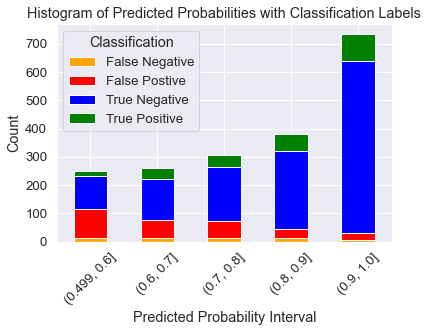

False positives with matching predicted and true labels: 0
False negatives with matching predicted and true labels: 0


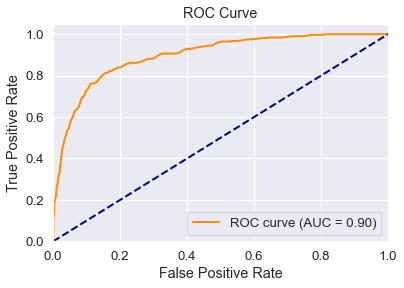

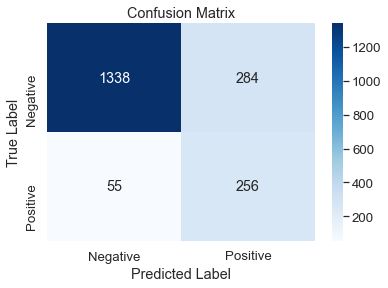

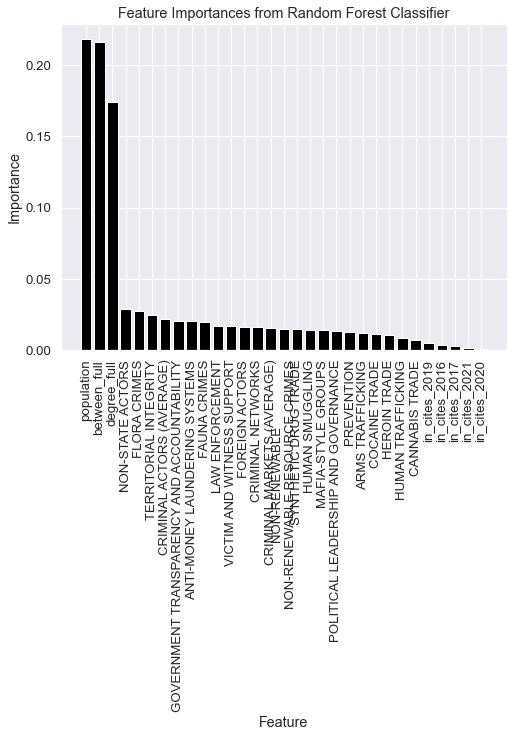

                                         Feature  Importance
23                                    population    0.218114
30                                  between_full    0.216303
29                                   degree_full    0.174491
22                              NON-STATE ACTORS    0.028765
8                                   FLORA CRIMES    0.027199
18                         TERRITORIAL INTEGRITY    0.024575
0                      CRIMINAL ACTORS (AVERAGE)    0.021625
16    GOVERNMENT TRANSPARENCY AND ACCOUNTABILITY    0.020546
19                 ANTI-MONEY LAUNDERING SYSTEMS    0.020410
9                                   FAUNA CRIMES    0.020023
17                               LAW ENFORCEMENT    0.016886
20                    VICTIM AND WITNESS SUPPORT    0.016763
3                                 FOREIGN ACTORS    0.016319
2                              CRIMINAL NETWORKS    0.015878
4                     CRIMINAL MARKETS (AVERAGE)    0.015605
10  NON-RENEWABLE\nNON-R

In [51]:
balanced_random_forest(X_scaled,y)

### Backward Feature Selection

In [ ]:
# Document the features output from the 'BFS Tuning' section here:
bfs_features = ['degree_full', 'between_full','NON-STATE ACTORS','TERRITORIAL INTEGRITY','NON-RENEWABLE\nNON-RENEWABLE RESOURCE CRIMES','POLITICAL LEADERSHIP AND GOVERNANCE','FLORA CRIMES','HUMAN TRAFFICKING','FOREIGN ACTORS', 'PREVENTION']

In [8]:
# Select depedendent and independent variables
node_feature_target = node_df_trimmed_80.columns[-4]

X = node_df_trimmed_80[bfs_features]
y = node_df_trimmed_80[node_feature_target]

print("Columns: ", bfs_features)
print("Target: ", node_feature_target)

Columns:  ['degree_full', 'between_full', 'NON-STATE ACTORS', 'TERRITORIAL INTEGRITY', 'NON-RENEWABLE\nNON-RENEWABLE RESOURCE CRIMES', 'POLITICAL LEADERSHIP AND GOVERNANCE', 'FLORA CRIMES', 'HUMAN TRAFFICKING', 'FOREIGN ACTORS', 'PREVENTION']
Target:  binary_incident_observed


In [9]:
# Initialize Scaler
scaler = StandardScaler()

# Fit
X_scaled = scaler.fit_transform(X)

              precision    recall  f1-score   support

           0       0.97      0.81      0.88      1622
           1       0.46      0.85      0.60       311

    accuracy                           0.82      1933
   macro avg       0.71      0.83      0.74      1933
weighted avg       0.88      0.82      0.84      1933

ROC AUC Score (predicted probabilities): 0.9083928380269685
Weighted F1 Score: 0.8358792647374937
Number of false positives identified: 307
Number of false negatives identified: 47


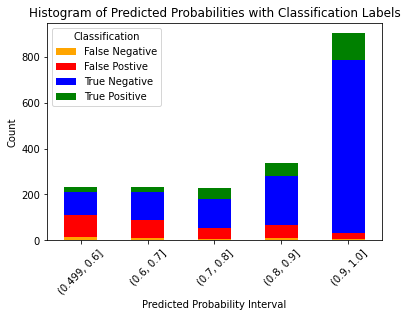

False positives with matching predicted and true labels: 0
False negatives with matching predicted and true labels: 0


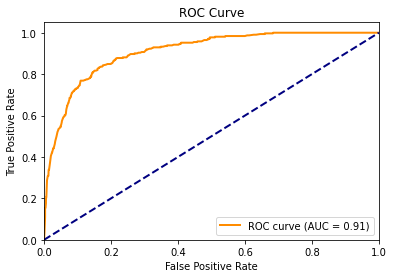

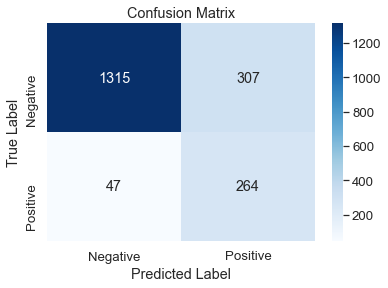

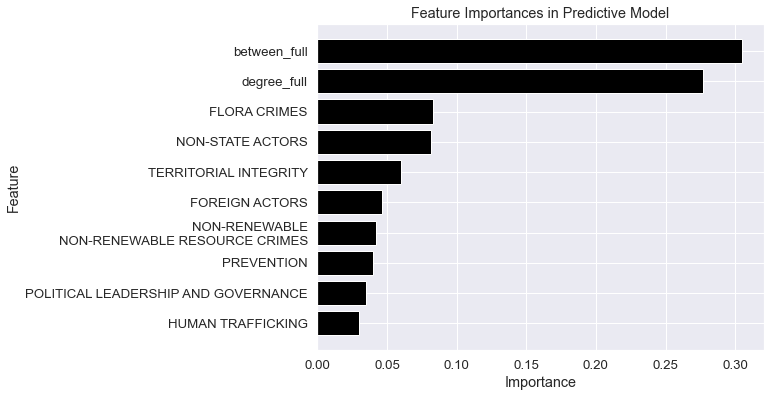

                                        Feature  Importance
1                                  between_full    0.305199
0                                   degree_full    0.276551
6                                  FLORA CRIMES    0.082835
2                              NON-STATE ACTORS    0.081445
3                         TERRITORIAL INTEGRITY    0.059899
8                                FOREIGN ACTORS    0.046397
4  NON-RENEWABLE\nNON-RENEWABLE RESOURCE CRIMES    0.042442
9                                    PREVENTION    0.040304
5           POLITICAL LEADERSHIP AND GOVERNANCE    0.034773
7                             HUMAN TRAFFICKING    0.030155
                                        Feature  Importance
1                                  between_full    0.305199
0                                   degree_full    0.276551
6                                  FLORA CRIMES    0.082835
2                              NON-STATE ACTORS    0.081445
3                         TERRITORIAL IN

In [10]:
balanced_rf, one, features = balanced_random_forest(X_scaled,y)
print(features)

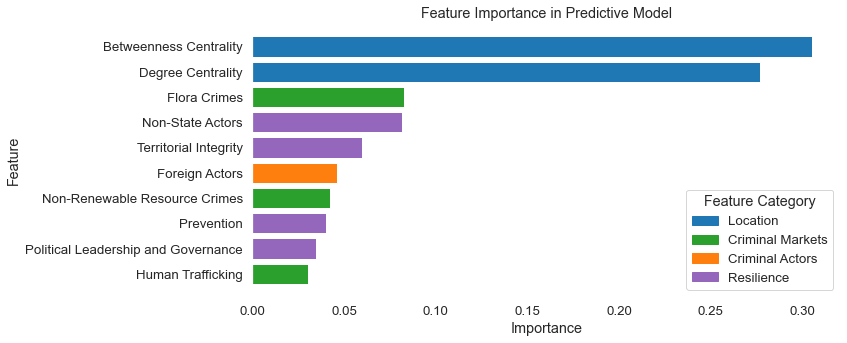

In [ ]:
features = pd.DataFrame({
    'Feature': [
        'between_full',
        'degree_full',
        'FLORA CRIMES',
        'NON-STATE ACTORS',
        'TERRITORIAL INTEGRITY',
        'FOREIGN ACTORS',
        'NON-RENEWABLE\nNON-RENEWABLE RESOURCE CRIMES',
        'PREVENTION',
        'POLITICAL LEADERSHIP AND GOVERNANCE',
        'HUMAN TRAFFICKING'
    ],
    'Importance': [
        0.305199,
        0.276551,
        0.082835,
        0.081445,
        0.059899,
        0.046397,
        0.042442,
        0.040304,
        0.034773,
        0.030155
    ]
})

# Mapping dictionary for renaming and capitalization
rename_map = {
    'between_full': 'Betweenness Centrality',
    'degree_full': 'Degree Centrality',
    'FLORA CRIMES': 'Flora Crimes',
    'NON-STATE ACTORS': 'Non-State Actors',
    'TERRITORIAL INTEGRITY': 'Territorial Integrity',
    'FOREIGN ACTORS': 'Foreign Actors',
    'NON-RENEWABLE\nNON-RENEWABLE RESOURCE CRIMES': 'Non-Renewable Resource Crimes',
    'PREVENTION': 'Prevention',
    'POLITICAL LEADERSHIP AND GOVERNANCE': 'Political Leadership and Governance',
    'HUMAN TRAFFICKING': 'Human Trafficking'
}

# Apply renaming and capitalization
features['Feature'] = features['Feature'].replace(rename_map)

# Define groups for color coding
groups = {
    'Location': ['Betweenness Centrality', 'Degree Centrality'],
    'Criminal Markets': ['Flora Crimes', 'Non-Renewable Resource Crimes', 'Human Trafficking'],
    'Criminal Actors': ['Foreign Actors'],
    'Resilience': ['Non-State Actors', 'Political Leadership and Governance', 'Territorial Integrity', 'Prevention']
}

# Assign colors to groups
color_map = {
    'Location': '#1f77b4',
    'Criminal Markets': '#2ca02c',
    'Criminal Actors': '#ff7f0e',
    'Resilience': '#9467bd'
}

# Assign colors based on groups
colors = []
for feature in features['Feature']:
    for group, features_in_group in groups.items():
        if feature in features_in_group:
            colors.append(color_map[group])
            break

# Clear any existing figures
plt.close('all')

# Plotting the feature importance horizontally
plt.figure(figsize=(12, 5), facecolor='white')  # Set figure facecolor to white
ax = plt.axes()
ax.set_facecolor("white")
bars = plt.barh(features['Feature'], features['Importance'], color=colors)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Predictive Model')


# Remove grid
plt.grid(True)

# Create custom legend entries based on color groups
legend_patches = [
    mpatches.Patch(color='#1f77b4', label='Location'),
    mpatches.Patch(color='#2ca02c', label='Criminal Markets'),
    mpatches.Patch(color='#ff7f0e', label='Criminal Actors'),
    mpatches.Patch(color='#9467bd', label='Resilience')
]

plt.legend(handles=legend_patches, loc='lower right', title = 'Feature Category', facecolor = 'white')  # Add legend

plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.tight_layout()


plt.savefig('feature_importance.png', dpi=1000)  # Adjust dpi as needed for quality

plt.show()


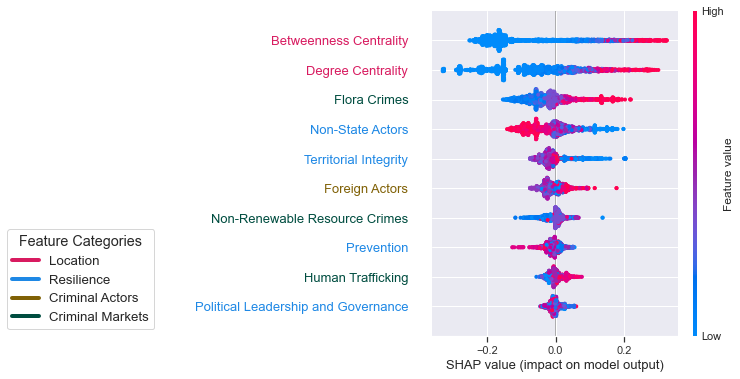

In [ ]:
# Define the features and their corresponding colors
bfs_features = ['Degree Centrality', 'Betweenness Centrality', 'Non-State Actors', 'Territorial Integrity', 'Non-Renewable Resource Crimes',
                'Political Leadership and Governance', 'Flora Crimes', 'Human Trafficking', 'Foreign Actors', 'Prevention']
feature_colors = {
    'Degree Centrality': '#D81B60',
    'Betweenness Centrality': '#D81B60',
    'Non-State Actors': '#1E88E5',
    'Territorial Integrity': '#1E88E5',
    'Non-Renewable Resource Crimes': '#004D40',
    'Political Leadership and Governance': '#1E88E5',
    'Flora Crimes': '#004D40',
    'Human Trafficking': '#004D40',
    'Foreign Actors': '#806106',
    'Prevention': '#1E88E5'
}

# Generate the SHAP values
explainer = shap.TreeExplainer(balanced_rf)
shap_values = explainer.shap_values(X_scaled)

# Create the SHAP summary plot with show=False to avoid displaying it immediately
shap.summary_plot(shap_values[1], X_scaled, feature_names=bfs_features, show=False)

# Get the current axes
ax = plt.gca()

# Customize the color and font weight of the y-axis labels
for label in ax.get_yticklabels():
    text = label.get_text()
    if text in feature_colors:
        label.set_color(feature_colors[text])
#         label.set_fontweight('bold')

# Create custom legend handles
legend_handles = [
    Line2D([0], [0], color='#D81B60', lw=4, label='Location'),
    Line2D([0], [0], color='#1E88E5', lw=4, label='Resilience'),
    Line2D([0], [0], color='#806106', lw=4, label='Criminal Actors'),
    Line2D([0], [0], color='#004D40', lw=4, label='Criminal Markets')
]

# Add the legend to the plot
ax.legend(handles=legend_handles, title="Feature Categories", loc='lower left', facecolor = 'white',bbox_to_anchor=(-1.75, 0))

# Show the customized plot
plt.show()


In [ ]:
combined_df = balanced_random_forest(X_scaled,y)
combined_df.to_csv('false_positives_and_negatives.csv')

##### BFS Model Tuning

In [ ]:
# List to store ROC-AUC scores
roc_auc_scores = []

# List to store selected feature counts
selected_feature_counts = []

# Range of n_features_to_select values
n_features_values = [5, 10, 15, 20, 25, 30]  # adjust this range as needed

# Initialize BalancedRandomForestClassifier
balanced_rf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)

# Perform backward feature selection with different values of n_features_to_select
for n_features_to_select in n_features_values:
    selector = SequentialFeatureSelector(balanced_rf, n_features_to_select=n_features_to_select, scoring='roc_auc', 
                                         direction='backward', cv=5)

    # Fit selector
    selector.fit(X_train, y_train)

    # Get selected feature indices
    selected_indices = selector.get_support(indices=True)

    # Get selected features
    selected_features = X.columns[selected_indices]

    # Store selected feature count
    selected_feature_counts.append(len(selected_indices))

    # Refit the model with selected features
    balanced_rf.fit(X_train[:, selected_indices], y_train)

    # Evaluate the model
    y_pred = balanced_rf.predict(X_test[:, selected_indices])

    # Calculate ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_pred)
    roc_auc_scores.append(roc_auc)

# Plot ROC-AUC scores against the number of predictors
plt.figure(figsize=(10, 6))
plt.plot(selected_feature_counts, roc_auc_scores, marker='o', linestyle='-')
plt.xlabel('Number of Predictors')
plt.ylabel('ROC-AUC Score')
plt.title('ROC-AUC Score vs. Number of Predictors')
plt.grid(True)
plt.xticks(selected_feature_counts)
plt.show()

In [ ]:
### Using the optimal number of features from the above cell, run this code with the number of features identified to get the final selected features
selector = SequentialFeatureSelector(balanced_rf, n_features_to_select=10, scoring='roc_auc', direction='backward', cv=5)

# Fit selector
selector.fit(X_train, y_train)

# Get selected feature indices
selected_indices = selector.get_support(indices=True)

# Get selected features
selected_features = X.columns[selected_indices]
print(selected_features)

# Store selected feature count
selected_feature_counts.append(len(selected_indices))

# Refit the model with selected features
balanced_rf.fit(X_train[:, selected_indices], y_train)

# Evaluate the model
y_pred = balanced_rf.predict(X_test[:, selected_indices])

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred)
roc_auc_scores.append(roc_auc)

# Output Results
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

# Feature Importances
feature_importances = balanced_rf.feature_importances_
feature_names = selected_features 
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(8, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'], color='black')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances from Random Forest Classifier')
plt.xticks(rotation=90)  
plt.show()

importance_df_sorted = importance_df.iloc[importance_df['Importance'].abs().argsort()[::-1]]
importance_df_sorted